# Stellargraph example: Relational Graph Convolutional Network (RGCN) on the AIFB relational dataset

This example demonstrates how use an RGCN [1] on the AIFB dataset with stellargraph. This dataset can be downloaded [here](https://figshare.com/articles/AIFB_DataSet/745364). 

The AIFB dataset describes the AIFB research institute in terms of its staff, research group, and publications. It contains ~8k entities, ~29k edges, and 45 different relationships or edge types. In (Bloehdorn et al 2007) the dataset was first used to predict the affiliation (i.e., research group) for people in the dataset. The dataset contains 178 members of a research group with 5 different research groups. The goal is to predict which research group a researcher belongs to.

[1] Modeling Relational Data with Graph Convolutional Networks. Thomas N. Kipf, Michael Schlichtkrull (2017). https://arxiv.org/pdf/1703.06103.pdf

First we load the required libraries.

In [1]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter

## Loading the data

We use `rdflib` to load the relational dataset into a networkx directed multigraph. Relational datasets are inherently directed with multiple edges types so we use the `MultiDiGraph` data structure to capture this information.

The relationship 'affiliation' indicates whether a researcher is affiliated with a reseach group e.g. (researcher, research group, affilliation). We use this relationship to label the nodes in the AIFB dataset.  After this we remove the affiliation relationship to prevent giving away the answer. The idea here is to test whether we can recover a 'missing' relationship. 

The relation 'employs' is the inverse of 'affilliation' and we remove this as well - otherwise it would give away the answer.

In [2]:
data_filepath = os.path.expanduser(os.path.join("~", "data", "aifbfixed_complete.n3"))

graph = Graph()
graph.parse(data_filepath, format='n3')
g_nx = rdflib_to_networkx_multidigraph(graph, edge_attrs=lambda s, p, o: {"label": str(p)})

affiliation = 'http://swrc.ontoware.org/ontology#affiliation'
employs = 'http://swrc.ontoware.org/ontology#employs'


people_nodes = [src for src, _, data in g_nx.edges(data=True) if data["label"] == affiliation] # the node ids of the researchers
labels = [dst for _, dst, data in g_nx.edges(data=True) if data["label"] == affiliation] # the research group each researcher belongs to

# remove 'affiliation' and 'employs' relationships
edges_to_remove = [e for e in g_nx.edges(keys=True, data=True) if e[-1]["label"] == affiliation or e[-1]["label"] == employs]
g_nx.remove_edges_from(edges_to_remove)

## Feature and target creation

We now create features and targets for machine learning.  Our nodes don't have features so we simply one-hot-encode each node and use there as our features and allow our model to learn from the graph structure.

In [3]:
# create an encoder
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

# create targets
# the targets are one hot encoded vectors indicating which research group a researcher belongs to
# targets of non-researcher entities are set to zero vectors 
# (we're not interested in predicting anything about non-researcher nodes)

node_index = dict(zip(g_nx.nodes, range(len(g_nx.nodes))))
people_idx = np.array([node_index[node] for node in people_nodes])

people_targets = encoder.fit_transform(np.array(labels)[:, np.newaxis])

targets = np.zeros((len(g_nx.nodes), people_targets.shape[-1]))
targets[people_idx, :] = people_targets

# index the node_data and targets dataframes by the nodes of the graph - this allows
# the nodes and edges of the graph to be matched with the targets and features
node_data = pd.DataFrame(np.eye(len(g_nx.nodes)), index=g_nx.nodes)
targets = pd.DataFrame(targets, index=g_nx.nodes)

# split data into train and test
train_data, test_data, train_targets, test_targets = model_selection.train_test_split(
    node_data.loc[people_nodes], targets.loc[people_nodes], train_size=0.8, test_size=None
)

## Machine Learning Graph Creation

Now we create a StellarDiGraph object to encapsulate the graph structure and the node features.  We'll then use the StellarDiGraph to create training and testing generators for ML.

In [4]:
G = sg.StellarDiGraph(
    g_nx, node_features=node_data
)

In [5]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_data.index, targets=train_targets)
test_gen = generator.flow(test_data.index, targets=test_targets)

## RGCN model creation and training

We use stellargraph to create an RGCN object. This creates a stack of relational graph convolutional layers. We add a softmax layer to transform the features created by RGCN into class predictions and create a keras model.  Then we train the model on the stellargraph generators.

Each RGCN layer creates a weight matrix for each relationship in the graph. If `num_bases==0` these weight matrices are completely independent. If `num_bases!=0` each weight matrix is a different linear combination of the same basis matrices. This introduces parameter sharing and reduces the number of the parameters in the model.  See the paper for more details.

In [6]:
rgcn = RGCN(
    layer_sizes=[16, 16], 
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    num_bases=10, 
    dropout=0.5,
)

In [7]:
x_in, x_out = rgcn.build()
predictions = Dense(train_targets.shape[-1], activation='softmax')(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_gen, 
    validation_data=test_gen,
    epochs=20)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

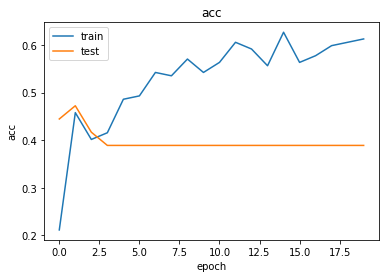

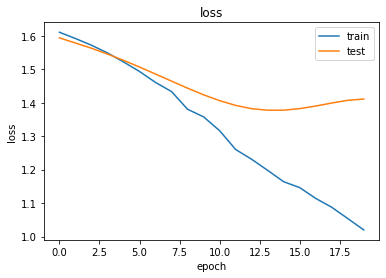

In [10]:
plot_history(history)

Now we assess the accuracy of our trained model on the test set - it does pretty well on this example dataset!

In [11]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.4112
	acc: 0.3889


## Node embeddings

We evaluate node embeddings as the activations of the output of the last graph convolution layer in the GCN layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of researchers in the node embedding space, with researchers from the same group belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(people_nodes, targets=people_targets)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict_generator(all_gen)

In [13]:
X = emb.squeeze(0)
y = np.argmax(people_targets, axis=1)

if X.shape[1] > 2:
    transform = TSNE 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=people_nodes)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=people_nodes)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

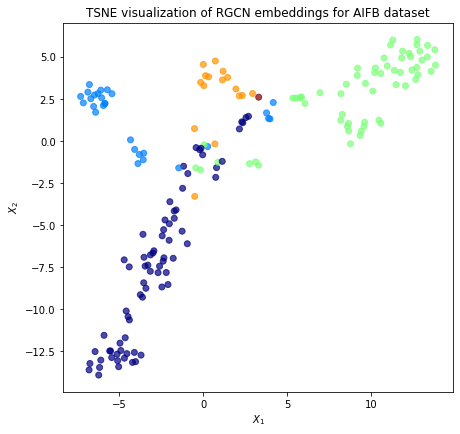

In [14]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of RGCN embeddings for AIFB dataset'.format(transform.__name__))
plt.show()

Aside from a slight overlap the classes are well seperated despite only using 2-dimensions. This indicates that our model is performing well at clustering the researchers into the right groups.